In [1]:
import numpy as np
import pandas as pd
from pymatgen.core.composition import Composition

import torch
import torch.nn as nn
import os
import re
import json
import pytorch_lightning as L
import wandb

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, StochasticWeightAveraging
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as Dataloader_PIG

from torch.optim import AdamW
from torch.optim.lr_scheduler import CyclicLR, CosineAnnealingLR, StepLR
from torch.nn import CrossEntropyLoss, L1Loss, MSELoss, ReLU, NLLLoss
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score, roc_auc_score, matthews_corrcoef
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

from roost.Data import data_from_composition_general
from roost.Model import Roost
from roost.utils import count_parameters, Scaler, DummyScaler, BCEWithLogitsLoss, Lamb, Lookahead, get_compute_device

from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

data_type_np = np.float32
data_type_torch = torch.float32
device=get_compute_device()


class RoostDataModule(L.LightningDataModule):
    def __init__(self, train_file: str , 
                 val_file: str, 
                 test_file: str, 
                 batch_size = 256,
                 features='onehot',
                 predictset='test'):
        super().__init__()
        self.train_path = train_file
        self.val_path = val_file
        self.test_path = test_file
        self.batch_size = batch_size
        self.features=features
        self.predictset=predictset

    def prepare_data(self):
        path='data/el-embeddings/'
        if(self.features == 'onehot'):
            with open(path+'onehot-embedding.json',"r") as f:
                elem_features=json.load(f)
        elif(self.features == 'matscholar'):
            with open(path+'matscholar-embedding.json',"r") as f:
                elem_features=json.load(f)
        elif(self.features == 'mat2vec'):
            with open(path+'mat2vec.json',"r") as f:
                elem_features=json.load(f)
        elif(self.features == 'cgcnn'):
            with open(path+'cgcnn-embedding.json',"r") as f:
                elem_features=json.load(f)
        
        ### loading and encoding trianing data
        if(re.search('.json', self.train_path )):
            self.data_train=pd.read_json(self.train_path)
        elif(re.search('.csv', self.train_path)):
            self.data_train=pd.read_csv(self.train_path)

        self.train_dataset = data_from_composition_general(self.data_train,elem_features)
        self.train_len = len(self.train_dataset)
        
        ### loading and encoding validation data
        if(re.search('.json', self.val_path )):
            self.data_val=pd.read_json(self.val_path)
        elif(re.search('.csv', self.val_path)):
            self.data_val=pd.read_csv(self.val_path)
        
        self.val_dataset = data_from_composition_general(self.data_val,elem_features)
        self.val_len = len(self.val_dataset)

        ### loading and encoding testing data
        if(re.search('.json', self.test_path )):
            self.data_test=pd.read_json(self.test_path)
        elif(re.search('.csv', self.test_path)):
            self.data_test=pd.read_csv(self.test_path)
        
        self.test_dataset = data_from_composition_general(self.data_test,elem_features)
        self.test_len = len(self.test_dataset)

    def train_dataloader(self):
        return Dataloader_PIG(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return Dataloader_PIG(self.val_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return Dataloader_PIG(self.test_dataset, batch_size=self.test_len, shuffle=False)
    
    def predict_dataloader(self):
        if(self.predictset=='test'):
            return Dataloader_PIG(self.test_dataset, batch_size=self.test_len, shuffle=False)
        elif(self.predictset=='val'):
            return Dataloader_PIG(self.val_dataset, batch_size=self.val_len, shuffle=False)
    

class RoostLightningClass(L.LightningModule):
    def __init__(self, **config):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()
        self.batch_size=config['data_params']['batch_size']
        self.out_dims=config['model_params']['output_dim']
        self.n_graphs=config['model_params']['n_graphs']
        self.comp_heads=config['model_params']['comp_heads']
        self.internal_elem_dim=config['model_params']['internal_elem_dim']
        self.setup=config['setup_params']
        self.model = Roost(**config['model_params'])
        self.classification = config['classification']
        self.loss_name = config['setup_params']['loss']
        # maybe need to do it, to unify Roost and CrabNet
        print('\n Model architecture: out_dims, n_graphs, heads, internal_elem_dim')
        print(f'{self.out_dims}, {self.n_graphs}, '
                  f'{self.comp_heads}, {self.internal_elem_dim}')
        print(f'Model size: {count_parameters(self.model)} parameters\n')
        if(config['classification']==True):
            if(config['setup_params']['loss'] == 'BCEWithLogitsLoss'):
                self.criterion = BCEWithLogitsLoss
            if(config['setup_params']['loss'] == 'CrossEntropyLoss'):
                self.criterion = nn.functional.cross_entropy
            if(re.search('.json', config['data_params']['train_path'])):
                train_data = pd.read_json(config['data_params']['train_path'])
            elif(re.search('.csv', config['data_params']['train_path'])):
                train_data = pd.read_csv(config['data_params']['train_path'])
            y = train_data['disorder'].values
            self.step_size = len(y)
            if(config['model_params']['output_dim']>1):
                classes = np.linspace(0,config['model_params']['output_dim']-1,config['model_params']['output_dim'],dtype=int)
            else:
                classes=np.array([0,1],dtype=int)
            set_classes=set(classes)
            y_classes = set(np.unique(y))
            if(set_classes.issubset(y_classes)):
                self.weight = torch.tensor(compute_class_weight(class_weight="balanced", classes=classes, y=y), dtype=data_type_torch).to(device)
            else:
                self.weight = torch.ones(len(classes), dtype=data_type_torch).to(device)
            if(self.loss_name == 'BCEWithLogitsLoss'):
                self.weight=self.weight[1]
    
        elif(config['classification']==False):
            self.criterion = L1Loss()
            if(re.search('.json', config['data_params']['train_path'] )):
                train_data=pd.read_json(config['data_params']['train_path'])
            elif(re.search('.csv', config['data_params']['train_path'])):
                train_data=pd.read_csv(config['data_params']['train_path'])
            y=train_data['disorder'].values
            self.step_size = len(y)
            self.scaler=Scaler(y)
        
    def forward(self, batch):
        out = self.model(batch.x, batch.edge_index, batch.pos, batch.batch)
        return out

    def configure_optimizers(self):
        if(self.setup['optim'] == 'AdamW'):
        # We use AdamW optimizer with MultistepLR scheduler as in the original Roost model
            optimizer = torch.optim.AdamW(self.parameters(),lr=self.setup['learning_rate'], 
                                        weight_decay=self.setup['weight_decay']) 
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=self.setup['gamma'])

        elif(self.setup['optim'] == 'Lamb'):
            base_optim = Lamb(params=self.model.parameters(),lr=0.001)
            optimizer = Lookahead(base_optimizer=base_optim)
            scheduler = CyclicLR(optimizer,
                                base_lr=self.setup['base_lr'],
                                max_lr=self.setup['max_lr'],
                                cycle_momentum=False,
                                step_size_up=self.step_size)

        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        logits=self(batch)
        if(self.classification == True):
            if(self.loss_name == 'BCEWithLogitsLoss'):
                loss=self.criterion(logits, batch.y,self.weight)
                prediction = torch.sigmoid(logits)
                y_pred = prediction.detach().cpu().numpy() > 0.5
            elif(self.loss_name == 'CrossEntropyLoss'):
                loss=self.criterion(logits, batch.y.long(),self.weight)
                prediction = torch.nn.functional.softmax(logits,dim=1)
                y_pred = torch.argmax(prediction,dim=1).detach().cpu().numpy()
            acc=balanced_accuracy_score(batch.y.detach().cpu().numpy(),y_pred)
            f1=f1_score(batch.y.detach().cpu().numpy(),y_pred,average='weighted')
            mc=matthews_corrcoef(batch.y.detach().cpu().numpy(),y_pred)

            self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
            self.log("train_f1", f1, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("train_mc", mc, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        elif(self.classification == False):
            y=self.scaler.scale(batch.y)
            loss=self.criterion(logits, y)
            y=self.scaler.unscale(y)
            prediction=self.scaler.unscale(logits)

            mse = mean_squared_error(y.detach().cpu().numpy(), prediction.detach().cpu().numpy())
            mae = mean_absolute_error(y.detach().cpu().numpy(), prediction.detach().cpu().numpy())
            self.log("train_mse", mse, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("train_mae", mae, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)

        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        return loss
    
    def validation_step(self, batch, batch_idx):
        logits=self(batch)
        if(self.classification == True):
            if(self.loss_name == 'BCEWithLogitsLoss'):
                loss=self.criterion(logits, batch.y,self.weight)
                prediction = torch.sigmoid(logits)
                y_pred = prediction.detach().cpu().numpy() > 0.5
            elif(self.loss_name == 'CrossEntropyLoss'):
                loss=self.criterion(logits, batch.y.long(),self.weight)
                prediction = torch.nn.functional.softmax(logits,dim=1)
                y_pred = torch.argmax(prediction,dim=1).detach().cpu().numpy()

            acc=balanced_accuracy_score(batch.y.detach().cpu().numpy(),y_pred)
            f1=f1_score(batch.y.detach().cpu().numpy(),y_pred,average='weighted')
            mc=matthews_corrcoef(batch.y.detach().cpu().numpy(),y_pred)

            self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
            self.log("val_f1", f1, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("val_mc", mc, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        elif(self.classification == False):
            y=self.scaler.scale(batch.y)
            loss=self.criterion(logits, y)
            y=self.scaler.unscale(y)
            prediction=self.scaler.unscale(logits)

            mse = mean_squared_error(y.detach().cpu().numpy(), prediction.detach().cpu().numpy())
            mae = mean_absolute_error(y.detach().cpu().numpy(), prediction.detach().cpu().numpy())
            self.log("val_mse", mse, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("val_mae", mae, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        return loss
    
    def test_step(self, batch, batch_idx):
        logits=self(batch)
        if(self.classification == True):
            if(self.loss_name == 'BCEWithLogitsLoss'):
                loss=self.criterion(logits, batch.y,self.weight)
                prediction = torch.sigmoid(logits)
                y_pred = prediction.detach().cpu().numpy() > 0.5
            elif(self.loss_name == 'CrossEntropyLoss'):
                loss=self.criterion(logits, batch.y.long(),self.weight)
                prediction = torch.nn.functional.softmax(logits,dim=1)
                y_pred = torch.argmax(prediction,dim=1).detach().cpu().numpy()

            acc=balanced_accuracy_score(batch.y.detach().cpu().numpy(),y_pred)
            f1=f1_score(batch.y.detach().cpu().numpy(),y_pred,average='weighted')
            mc=matthews_corrcoef(batch.y.detach().cpu().numpy(),y_pred)

            self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
            self.log("test_f1", f1, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("test_mc", mc, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)

        elif(self.classification == False):
            y=self.scaler.scale(batch.y)
            loss=self.criterion(logits, y)
            y=self.scaler.unscale(y)
            prediction=self.scaler.unscale(logits)

            mse = mean_squared_error(y.detach().cpu().numpy(), prediction.detach().cpu().numpy())
            mae = mean_absolute_error(y.detach().cpu().numpy(), prediction.detach().cpu().numpy())
            self.log("test_mse", mse, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("test_mae", mae, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        logits=self(batch)
        if(self.classification == True):
            if(self.loss_name == 'BCEWithLogitsLoss'):
                prediction = torch.sigmoid(logits)
                y_pred = prediction.detach().cpu().numpy() > 0.5
            elif(self.loss_name == 'CrossEntropyLoss'):
                prediction = torch.nn.functional.softmax(logits,dim=1)
                y_pred = torch.argmax(prediction,dim=1).detach().cpu().numpy()
            return batch.y.view(-1).detach().cpu().numpy(), prediction, y_pred
        elif(self.classification == False):
            prediction=self.scaler.unscale(logits)
            return batch.y.view(-1).detach().cpu().numpy(), prediction

In [151]:
with open('roost/roost_config.json','r') as f:
    config=json.load(f)

L.seed_everything(config['seed'])

disorder_data = RoostDataModule(config['data_params']['train_path'],
                                   config['data_params']['val_path'],
                                   config['data_params']['test_path'], features=config['data_params']['embed'])
disorder_data.prepare_data()
predictloader=disorder_data.predict_dataloader()
for x in predictloader:
    datalength=len(x.y)

prediction_roost=np.zeros((10,datalength))

for i in range(10):
    name='roost-disorder-'+str(i)
    model = RoostLightningClass.load_from_checkpoint('roost_models/roost_trained_models/'+name+'.ckpt')
    model.eval()
    for x in predictloader:
        with torch.no_grad():
            logits = model(x)
            pred = torch.sigmoid(logits)
            prediction_roost[i,:]=pred.detach().cpu().numpy()

Global seed set to 30



 Model architecture: out_dims, n_graphs, heads, internal_elem_dim
1, 3, 3, 64
Model size: 2426169 parameters


 Model architecture: out_dims, n_graphs, heads, internal_elem_dim
1, 3, 3, 64
Model size: 2426169 parameters


 Model architecture: out_dims, n_graphs, heads, internal_elem_dim
1, 3, 3, 64
Model size: 2426169 parameters


 Model architecture: out_dims, n_graphs, heads, internal_elem_dim
1, 3, 3, 64
Model size: 2426169 parameters


 Model architecture: out_dims, n_graphs, heads, internal_elem_dim
1, 3, 3, 64
Model size: 2426169 parameters


 Model architecture: out_dims, n_graphs, heads, internal_elem_dim
1, 3, 3, 64
Model size: 2426169 parameters


 Model architecture: out_dims, n_graphs, heads, internal_elem_dim
1, 3, 3, 64
Model size: 2426169 parameters



In [ ]:
y_pred_proba_roost=np.mean(prediction,axis=0)
y_pred_roost = y_pred_proba_roost > 0.5

In [2]:
import numpy as np
import pandas as pd
import collections
from collections import OrderedDict
import pytorch_lightning as L
import os
import re
import json
import tqdm

from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score, f1_score, precision_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, matthews_corrcoef, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split

from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, StochasticWeightAveraging
# from pytorch_lightning.loggers.wandb import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer
from torchmetrics.functional import mean_squared_error, mean_absolute_error

from pymatgen.core.composition import Composition
from crabnet.kingcrab import CrabNet

import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CyclicLR, CosineAnnealingLR, StepLR

from crabnet.utils.utils import (Lamb, Lookahead, RobustL1, BCEWithLogitsLoss,
                         EDMDataset, get_edm, Scaler, DummyScaler, count_parameters)
from crabnet.utils.get_compute_device import get_compute_device
# from crabnet.utils.composition import _element_composition, get_sym_dict, parse_formula, CompositionError
#from utils.optim import SWA

data_type_np = np.float32
data_type_torch = torch.float32

import wandb


class CrabNetDataModule(L.LightningDataModule):
    def __init__(self, train_file: str , 
                 val_file: str, 
                 test_file: str,
                 n_elements ='infer', 
                 classification = False,
                 elem_prop='mat2vec',
                 batch_size = 2**10,
                 scale = True,
                 pin_memory = True,
                 predictset='test'):
        super().__init__()
        self.train_path = train_file
        self.val_path = val_file
        self.test_path = test_file
        self.batch_size = batch_size
        self.n_elements=n_elements
        self.pin_memory = pin_memory
        self.scale = scale
        self.classification = classification
        self.elem_prop=elem_prop
        self.predictset=predictset

    def prepare_data(self):
        ### loading and encoding trianing data
        if(re.search('.json', self.train_path )):
            self.data_train=pd.read_json(self.train_path)
        elif(re.search('.csv', self.train_path)):
            self.data_train=pd.read_csv(self.train_path)

        self.train_main_data = list(get_edm(self.data_train, elem_prop=self.elem_prop,
                                      n_elements=self.n_elements,
                                      inference=False,
                                      verbose=True,
                                      drop_unary=False,
                                      scale=self.scale))
        
        self.train_len_data = len(self.train_main_data[0])
        self.train_n_elements = self.train_main_data[0].shape[1]//2

        print(f'loading data with up to {self.train_n_elements:0.0f} '
              f'elements in the formula for training')
        
        ### loading and encoding validation data
        if(re.search('.json', self.val_path )):
            self.data_val=pd.read_json(self.val_path)
        elif(re.search('.csv', self.val_path)):
            self.data_val=pd.read_csv(self.val_path)
        
        self.val_main_data = list(get_edm(self.data_val, elem_prop=self.elem_prop,
                                      n_elements=self.n_elements,
                                      inference=True,
                                      verbose=True,
                                      drop_unary=False,
                                      scale=self.scale))
        
        self.val_len_data = len(self.val_main_data[0])
        self.val_n_elements = self.val_main_data[0].shape[1]//2

        print(f'loading data with up to {self.val_n_elements:0.0f} '
              f'elements in the formula for validation')
        
        ### loading and encoding testing data
        if(re.search('.json', self.test_path )):
            self.data_test=pd.read_json(self.test_path)
        elif(re.search('.csv', self.test_path)):
            self.data_test=pd.read_csv(self.test_path)
        
        self.test_main_data = list(get_edm(self.data_test, elem_prop=self.elem_prop,
                                      n_elements=self.n_elements,
                                      inference=True,
                                      verbose=True,
                                      drop_unary=False,
                                      scale=self.scale))
        
        self.test_len_data = len(self.test_main_data[0])
        self.test_n_elements = self.test_main_data[0].shape[1]//2

        print(f'loading data with up to {self.test_n_elements:0.0f} '
              f'elements in the formula for testing')

        self.train_dataset = EDMDataset(self.train_main_data, self.train_n_elements)
        self.val_dataset = EDMDataset(self.val_main_data, self.val_n_elements)
        self.test_dataset = EDMDataset(self.test_main_data, self.test_n_elements)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          pin_memory=self.pin_memory, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                        pin_memory=self.pin_memory, shuffle=False)
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.test_len_data,
                        pin_memory=self.pin_memory, shuffle=False)
    def predict_dataloader(self):
        if(self.predictset=='test'):
            return DataLoader(self.test_dataset, batch_size=self.test_len_data,
                        pin_memory=self.pin_memory, shuffle=False)
        elif(self.predictset=='val'):
            return DataLoader(self.val_dataset, batch_size=self.val_len_data,
                        pin_memory=self.pin_memory, shuffle=False)


class CrabNetLightning(L.LightningModule):
    def __init__(self, **config):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        self.model = CrabNet(out_dims=config['out_dims'],
                             d_model=config['d_model'],
                             N=config['N'],
                             heads=config['heads'])
        print('\nModel architecture: out_dims, d_model, N, heads')
        print(f'{self.model.out_dims}, {self.model.d_model}, '
                  f'{self.model.N}, {self.model.heads}')
        print(f'Model size: {count_parameters(self.model)} parameters\n')

        ### here we define some important parameters
        self.fudge=config['fudge']
        self.batch_size=config['batch_size']
        self.classification = config['classification']
        self.base_lr=config['base_lr']
        self.max_lr=config['max_lr']
        ### here we also need to initialise scaler based on training data
        if(re.search('.json', config['train_path'] )):
            train_data=pd.read_json(config['train_path'])
        elif(re.search('.csv', config['train_path'])):
            train_data=pd.read_csv(config['train_path'])
        
        y=train_data['target'].values
        self.step_size = len(y)
        if self.classification:
            self.scaler = DummyScaler(y)
        else:
            self.scaler = Scaler(y)
        ### we also define loss function based on task
        if self.classification:
            if(np.sum(y)>0):
                self.weight=torch.tensor(((len(y)-np.sum(y))/np.sum(y))).cuda()
            print("Using BCE loss for classification task")
            self.criterion = BCEWithLogitsLoss
        else:
            print("Using RobustL1 loss for regression task")
            self.criterion = RobustL1

    def forward(self, src, frac):
        out=self.model(src, frac)
        return out

    def configure_optimizers(self):
        base_optim = Lamb(params=self.model.parameters(),lr=0.001)
        optimizer = Lookahead(base_optimizer=base_optim)
        lr_scheduler = CyclicLR(optimizer,
                                base_lr=self.base_lr,
                                max_lr=self.max_lr,
                                cycle_momentum=False,
                                step_size_up=self.step_size)
        # lr_scheduler=StepLR(optimizer,
        #                     step_size=3,
        #                     gamma=0.5)
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        X, y, formula = batch
        y = self.scaler.scale(y)
        src, frac = X.squeeze(-1).chunk(2, dim=1)
        frac = frac * (1 + (torch.randn_like(frac))*self.fudge)
        frac = torch.clamp(frac, 0, 1)
        frac[src == 0] = 0
        frac = frac / frac.sum(dim=1).unsqueeze(1).repeat(1, frac.shape[-1])
        
        output = self(src, frac)
        prediction, uncertainty = output.chunk(2, dim=-1)
        loss = self.criterion(prediction.view(-1),
                              uncertainty.view(-1),
                              y.view(-1), self.weight)
        
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        uncertainty = torch.exp(uncertainty) * self.scaler.std
        prediction = self.scaler.unscale(prediction)
        if self.classification:
            prediction = torch.sigmoid(prediction)
            y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
            acc=balanced_accuracy_score(y.view(-1).detach().cpu().numpy(),y_pred)
            f1=f1_score(y.view(-1).detach().cpu().numpy(),y_pred,average='weighted')
            mc=matthews_corrcoef(y.view(-1).detach().cpu().numpy(),y_pred)
            
            self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
            self.log("train_f1", f1, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("train_mc", mc, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        else:
            mse = mean_squared_error(prediction.view(-1),y.view(-1))
            mae = mean_absolute_error(prediction.view(-1),y.view(-1))
            self.log("train_mse", mse, on_step=True, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("train_mae", mae, on_step=True, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, batch_idx):
        X, y, formula = batch
        y = self.scaler.scale(y)
        src, frac = X.squeeze(-1).chunk(2, dim=1)
        frac = frac * (1 + (torch.randn_like(frac))*self.fudge)
        frac = torch.clamp(frac, 0, 1)
        frac[src == 0] = 0
        frac = frac / frac.sum(dim=1).unsqueeze(1).repeat(1, frac.shape[-1])
        
        output = self(src, frac)
        prediction, uncertainty = output.chunk(2, dim=-1)
        val_loss = self.criterion(prediction.view(-1),
                              uncertainty.view(-1),
                              y.view(-1), self.weight)
        self.log("val_loss", val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
        uncertainty = torch.exp(uncertainty) * self.scaler.std
        prediction = self.scaler.unscale(prediction)
        if self.classification:
            prediction = torch.sigmoid(prediction)
            y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
            acc=balanced_accuracy_score(y.view(-1).detach().cpu().numpy(),y_pred)
            f1=f1_score(y.view(-1).detach().cpu().numpy(),y_pred,average='weighted')
            mc=matthews_corrcoef(y.view(-1).detach().cpu().numpy(),y_pred)
            
            self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
            self.log("val_f1", f1, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("val_mc", mc, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        else:
            mse = mean_squared_error(prediction.view(-1),y.view(-1))
            mae = mean_absolute_error(prediction.view(-1),y.view(-1))
            self.log("val_mse", mse, on_step=True, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("val_mae", mae, on_step=True, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        return val_loss
     
    def test_step(self, batch, batch_idx):
        X, y, formula = batch
        y = self.scaler.scale(y)
        src, frac = X.squeeze(-1).chunk(2, dim=1)
        frac = frac * (1 + (torch.randn_like(frac))*self.fudge)
        frac = torch.clamp(frac, 0, 1)
        frac[src == 0] = 0
        frac = frac / frac.sum(dim=1).unsqueeze(1).repeat(1, frac.shape[-1])
        
        output = self(src, frac)
        prediction, uncertainty = output.chunk(2, dim=-1)
        uncertainty = torch.exp(uncertainty) * self.scaler.std
        prediction = self.scaler.unscale(prediction)
        if self.classification:
            prediction = torch.sigmoid(prediction)
            y_pred = prediction.view(-1).detach().cpu().numpy() > 0.5
            acc=balanced_accuracy_score(y.view(-1).detach().cpu().numpy(),y_pred)
            f1=f1_score(y.view(-1).detach().cpu().numpy(),y_pred,average='weighted')
            mc=matthews_corrcoef(y.view(-1).detach().cpu().numpy(),y_pred)
            
            self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size)
            self.log("test_f1", f1, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("test_mc", mc, on_step=False, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        else:
            mse = mean_squared_error(prediction.view(-1),y.view(-1))
            mae = mean_absolute_error(prediction.view(-1),y.view(-1))
            self.log("test_mse", mse, on_step=True, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
            self.log("test_mae", mae, on_step=True, on_epoch=True, prog_bar=False, logger=True, batch_size=self.batch_size)
        return 
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        X, y, formula = batch
        y = self.scaler.scale(y)
        src, frac = X.squeeze(-1).chunk(2, dim=1)
        frac = frac * (1 + (torch.randn_like(frac))*self.fudge)
        frac = torch.clamp(frac, 0, 1)
        frac[src == 0] = 0
        frac = frac / frac.sum(dim=1).unsqueeze(1).repeat(1, frac.shape[-1])
        
        output = self(src, frac)
        prediction, uncertainty = output.chunk(2, dim=-1)
        uncertainty = torch.exp(uncertainty) * self.scaler.std
        prediction = self.scaler.unscale(prediction)
        if self.classification:
            prediction = torch.sigmoid(prediction)
        return formula, prediction, uncertainty

In [ ]:
with open('crabnet/crabnet_config.json','r') as f:
        config=json.load(f)
disorder_data = CrabNetDataModule(config['train_path'],
                                   config['val_path'],
                                   config['test_path'],
                                   classification = config['classification'])
disorder_data.prepare_data()
predictloader=disorder_data.predict_dataloader()
for x in predictloader:
    _,y_true,_=x
    datalength=len(y_true)

prediction_crabnet=np.zeros((10,datalength))

for i in range(10):
    name='crabnet-disorder-'+str(i)
    model = CrabNetLightning.load_from_checkpoint('crabnet_models/crabnet_trained_models/'+name+'.ckpt')
    trainer = Trainer()
    formula, prediction, uncertainty=trainer.predict(model=model,datamodule=disorder_data)[0]
    prediction_crabnet[i,:]=prediction.detach().cpu().numpy()[:,0]
    

Generating EDM: 100%|██████████| 75091/75091 [00:00<00:00, 212224.18formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 8344/8344 [00:00<00:00, 203327.11formulae/s]


loading data with up to 16 elements in the formula for validation


Generating EDM: 100%|██████████| 20859/20859 [00:00<00:00, 200383.38formulae/s]


loading data with up to 16 elements in the formula for testing


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Model size: 11987206 parameters

Using BCE loss for classification task


c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 75091/75091 [00:00<00:00, 206773.62formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 8344/8344 [00:00<00:00, 203323.57formulae/s]


loading data with up to 16 elements in the formula for validation


Generating EDM: 100%|██████████| 20859/20859 [00:00<00:00, 204312.32formulae/s]
c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


loading data with up to 16 elements in the formula for testing


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Model size: 11987206 parameters

Using BCE loss for classification task


c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 75091/75091 [00:00<00:00, 208678.35formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 8344/8344 [00:00<00:00, 203324.75formulae/s]


loading data with up to 16 elements in the formula for validation


Generating EDM: 100%|██████████| 20859/20859 [00:00<00:00, 202447.70formulae/s]


loading data with up to 16 elements in the formula for testing


c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Model size: 11987206 parameters

Using BCE loss for classification task


c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 75091/75091 [00:00<00:00, 210636.95formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 8344/8344 [00:00<00:00, 203452.41formulae/s]


loading data with up to 16 elements in the formula for validation


Generating EDM: 100%|██████████| 20859/20859 [00:00<00:00, 201937.43formulae/s]
c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


loading data with up to 16 elements in the formula for testing


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Model size: 11987206 parameters

Using BCE loss for classification task


c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 75091/75091 [00:00<00:00, 208754.84formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 8344/8344 [00:00<00:00, 203318.84formulae/s]


loading data with up to 16 elements in the formula for validation


Generating EDM: 100%|██████████| 20859/20859 [00:00<00:00, 204312.32formulae/s]
c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


loading data with up to 16 elements in the formula for testing


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Model size: 11987206 parameters

Using BCE loss for classification task


c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 75091/75091 [00:00<00:00, 207226.53formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 8344/8344 [00:00<00:00, 202559.82formulae/s]


loading data with up to 16 elements in the formula for validation


Generating EDM: 100%|██████████| 20859/20859 [00:00<00:00, 203694.40formulae/s]
c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


loading data with up to 16 elements in the formula for testing


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Model size: 11987206 parameters

Using BCE loss for classification task


c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 75091/75091 [00:00<00:00, 209447.29formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 8344/8344 [00:00<00:00, 203327.11formulae/s]


loading data with up to 16 elements in the formula for validation


Generating EDM: 100%|██████████| 20859/20859 [00:00<00:00, 202325.97formulae/s]
c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


loading data with up to 16 elements in the formula for testing


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Model size: 11987206 parameters

Using BCE loss for classification task


c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 75091/75091 [00:00<00:00, 209748.72formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 8344/8344 [00:00<00:00, 203317.66formulae/s]


loading data with up to 16 elements in the formula for validation


Generating EDM: 100%|██████████| 20859/20859 [00:00<00:00, 202319.89formulae/s]
c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


loading data with up to 16 elements in the formula for testing


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Model size: 11987206 parameters

Using BCE loss for classification task


c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 75091/75091 [00:00<00:00, 209550.83formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 8344/8344 [00:00<00:00, 198476.00formulae/s]


loading data with up to 16 elements in the formula for validation


Generating EDM: 100%|██████████| 20859/20859 [00:00<00:00, 204305.16formulae/s]
c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


loading data with up to 16 elements in the formula for testing


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Model size: 11987206 parameters

Using BCE loss for classification task


c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 75091/75091 [00:00<00:00, 202207.84formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 8344/8344 [00:00<00:00, 203321.21formulae/s]


loading data with up to 16 elements in the formula for validation


Generating EDM: 100%|██████████| 20859/20859 [00:00<00:00, 165792.10formulae/s]
c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


loading data with up to 16 elements in the formula for testing


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Model size: 11987206 parameters

Using BCE loss for classification task


c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 75091/75091 [00:00<00:00, 201664.44formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 8344/8344 [00:00<00:00, 193861.71formulae/s]


loading data with up to 16 elements in the formula for validation


Generating EDM: 100%|██████████| 20859/20859 [00:00<00:00, 202318.02formulae/s]
c:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


loading data with up to 16 elements in the formula for testing


Predicting: 0it [00:00, ?it/s]

In [ ]:
y_pred_proba_roost=np.mean(prediction_roost,axis=0)
y_pred_roost = y_pred_proba_roost > 0.5
y_pred_proba_crabnet=np.mean(prediction_crabnet,axis=0)
y_pred_crabnet = y_pred_proba_crabnet > 0.5

In [ ]:
balanced_accuracy_score(y_true,y_pred_crabnet), balanced_accuracy_score(y_true,y_pred_roost)

(0.9141226702028342, 0.8615996055104127)

In [ ]:
f1_score(y_true,y_pred_crabnet,average='weighted'),f1_score(y_true,y_pred_roost,average='weighted')

(0.9106009640325206, 0.857484201453588)

In [ ]:
precision_score(y_true,y_pred_crabnet),precision_score(y_true,y_pred_roost)

(0.9536934950385888, 0.9185457087921692)

In [ ]:
recall_score(y_true,y_pred_crabnet),recall_score(y_true,y_pred_roost)

(0.8941634860050891, 0.8357188295165394)

In [ ]:
matthews_corrcoef(y_true,y_pred_crabnet),matthews_corrcoef(y_true,y_pred_roost)

(0.8175099004702066, 0.7110756087614373)

In [ ]:
roc_auc_score(y_true,y_pred_proba_crabnet),roc_auc_score(y_true,y_pred_proba_roost)

(0.9662498129926128, 0.9327792442689724)

In [3]:
import numpy as np
import pandas as pd
from matminer.featurizers.composition import ElementProperty, Stoichiometry 
from matminer.featurizers.composition import ValenceOrbital, IonProperty, AtomicOrbitals
from matplotlib import pyplot as plt
from matminer.datasets import load_dataset
from matminer.featurizers.base import MultipleFeaturizer

from matminer.featurizers.conversions import DictToObject, StrToComposition
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy import stats
from tqdm import tqdm_notebook as tqdm

from pymatgen.core.composition import Composition

In [4]:
df_train=pd.read_csv('data/roost_data/train.csv',usecols=['formula', 'disorder'])
df_val=pd.read_csv('data/roost_data/val.csv',usecols=['formula', 'disorder'])
df_test=pd.read_csv('data/roost_data/test.csv',usecols=['formula', 'disorder'])
df_train['composition']=[Composition(df_train.iloc[i]['formula']).fractional_composition for i in range(len(df_train))]
df_val['composition']=[Composition(df_val.iloc[i]['formula']).fractional_composition for i in range(len(df_val))]
df_test['composition']=[Composition(df_test.iloc[i]['formula']).fractional_composition for i in range(len(df_test))]

In [5]:
featurizer = MultipleFeaturizer([
    ElementProperty.from_preset('magpie'),
    Stoichiometry(),
    ValenceOrbital()
])
flen=len(featurizer.featurize(df_train['composition'][0]))
features_train=np.zeros((len(df_train),flen))
features_val=np.zeros((len(df_val),flen))
features_test=np.zeros((len(df_test),flen))
for i,comp in enumerate(df_train['composition']):
    features_train[i,:]=featurizer.featurize(comp)
features_train=np.nan_to_num(features_train, copy=True, nan=0.0, posinf=None, neginf=None)
for i,comp in enumerate(df_val['composition']):
    features_val[i,:]=featurizer.featurize(comp)
features_val=np.nan_to_num(features_val, copy=True, nan=0.0, posinf=None, neginf=None)
for i,comp in enumerate(df_test['composition']):
    features_test[i,:]=featurizer.featurize(comp)
features_test=np.nan_to_num(features_test, copy=True, nan=0.0, posinf=None, neginf=None)

C:\Users\patykova\.conda\envs\roost\lib\site-packages\pymatgen\core\periodic_table.py:212: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


In [6]:
ytrain=df_train['disorder'].values
yval=df_val['disorder'].values
ytest=df_test['disorder'].values
Xtrain=features_train
Xval=features_val
Xtest=features_test

In [7]:
RF=RandomForestClassifier()
RF.fit(Xtrain,ytrain)
yproba_rf_val=RF.predict_proba(Xval)[:,1]         

In [8]:
from sklearn import preprocessing

Xtrain_normalized = preprocessing.normalize(Xtrain, norm='l2')
Xval_normalized = preprocessing.normalize(Xval, norm='l2')
Xtest_normalized = preprocessing.normalize(Xtest, norm='l2')

In [9]:
scaler = preprocessing.StandardScaler().fit(Xtrain)
Xtrain_scaled = scaler.transform(Xtrain)
Xval_scaled = scaler.transform(Xval)
Xtest_scaled = scaler.transform(Xtest)


In [34]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
NN=KNeighborsClassifier(n_neighbors=3)
NN.fit(Xtrain_scaled,ytrain)
yproba_nn_val=NN.predict_proba(Xval_scaled)[:,1]

In [62]:
ypred_nn_test=NN.predict(Xtest_scaled)
yproba_nn_test=NN.predict_proba(Xtest_scaled)[:,1]

In [55]:
balanced_accuracy_score(ytest,ypred_nn_test)

0.7882624314216647

In [56]:
recall_score(ytest,ypred_nn_test)

0.834764631043257

In [57]:
precision_score(ytest,ypred_nn_test)

0.8307351428345335

In [58]:
f1_score(ytest,ypred_nn_test)

0.8327450124935549

In [59]:
matthews_corrcoef(ytest,ypred_nn_test)

0.5772612523236575

In [63]:
roc_auc_score(ytest,yproba_nn_test)

0.8576735495753127

In [31]:
with open('crabnet/crabnet_config.json','r') as f:
    config_crabnet=json.load(f)

L.seed_everything(config_crabnet['random_seed'])

disorder_data_crabnet = CrabNetDataModule(config_crabnet['train_path'],
                                   config_crabnet['val_path'],
                                   config_crabnet['test_path'],
                                   classification = config_crabnet['classification'],predictset='val')
disorder_data_crabnet.prepare_data()
valloader=disorder_data_crabnet.predict_dataloader()
for x in valloader:
    _,y_true,_=x
    datalength=len(y_true)

for i in range(1):
    name='crabnet-disorder-'+str(i)
    model_crabnet = CrabNetLightning.load_from_checkpoint('crabnet_models/crabnet_trained_models/'+name+'.ckpt')
    trainer = Trainer()
    formula, prediction, uncertainty=trainer.predict(model=model_crabnet,datamodule=disorder_data_crabnet)[0]
    yproba_crabnet_val=prediction.detach().cpu().numpy()[:,0]  

Global seed set to 29
Generating EDM: 100%|██████████| 75091/75091 [00:00<00:00, 216219.40formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 8344/8344 [00:00<00:00, 210027.32formulae/s]


loading data with up to 16 elements in the formula for validation


Generating EDM: 100%|██████████| 20859/20859 [00:00<00:00, 212653.34formulae/s]


loading data with up to 16 elements in the formula for testing


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Model size: 11987206 parameters

Using BCE loss for classification task


C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 75091/75091 [00:00<00:00, 217469.30formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 8344/8344 [00:00<00:00, 203327.11formulae/s]


loading data with up to 16 elements in the formula for validation


Generating EDM: 100%|██████████| 20859/20859 [00:00<00:00, 214842.41formulae/s]


loading data with up to 16 elements in the formula for testing


C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [32]:
with open('roost/roost_config.json','r') as f:
    config_roost=json.load(f)

disorder_data_roost = RoostDataModule(config_roost['data_params']['train_path'],
                                   config_roost['data_params']['val_path'],
                                   config_roost['data_params']['test_path'], features=config_roost['data_params']['embed'],predictset='val')
disorder_data_roost.prepare_data()
valloader=disorder_data_roost.predict_dataloader()

for i in range(1):
    name='roost-disorder-'+str(i)
    model_roost = RoostLightningClass.load_from_checkpoint('roost_models/roost_trained_models/'+name+'.ckpt')
    model_roost.eval()
    for x in valloader:
        with torch.no_grad():
            logits = model_roost(x)
            yproba_roost_val = torch.sigmoid(logits).detach().cpu().numpy()


 Model architecture: out_dims, n_graphs, heads, internal_elem_dim
1, 3, 3, 64
Model size: 2426169 parameters



In [35]:
X = np.stack((yproba_rf_val,yproba_nn_val, yproba_roost_val,yproba_crabnet_val), axis=1)
yval=y_true

In [36]:
from sklearn.linear_model import LogisticRegression

meta_model=LogisticRegression()
meta_model.fit(X,y_true)

LogisticRegression()

In [37]:
meta_model.score(X,y_true)

0.9083173537871524

In [39]:
yproba_rf_test=RF.predict_proba(Xtest)[:,1] 
yproba_nn_test=NN.predict_proba(Xtest_scaled)[:,1] 

In [40]:
with open('crabnet/crabnet_config.json','r') as f:
    config_crabnet=json.load(f)

disorder_data_crabnet = CrabNetDataModule(config_crabnet['train_path'],
                                   config_crabnet['val_path'],
                                   config_crabnet['test_path'],
                                   classification = config_crabnet['classification'],predictset='test')
disorder_data_crabnet.prepare_data()
testloader=disorder_data_crabnet.predict_dataloader()
for x in testloader:
    _,y_true_test,_=x

for i in range(1):
    name='crabnet-disorder-'+str(i)
    model_crabnet = CrabNetLightning.load_from_checkpoint('crabnet_models/crabnet_trained_models/'+name+'.ckpt')
    trainer = Trainer()
    formula, prediction, uncertainty=trainer.predict(model=model_crabnet,datamodule=disorder_data_crabnet)[0]
    yproba_crabnet_test=prediction.detach().cpu().numpy()[:,0]  

Generating EDM: 100%|██████████| 75091/75091 [00:00<00:00, 213636.51formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 8344/8344 [00:00<00:00, 213757.74formulae/s]


loading data with up to 16 elements in the formula for validation


Generating EDM: 100%|██████████| 20859/20859 [00:00<00:00, 213737.05formulae/s]


loading data with up to 16 elements in the formula for testing


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Model size: 11987206 parameters

Using BCE loss for classification task


C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Generating EDM: 100%|██████████| 75091/75091 [00:00<00:00, 216064.25formulae/s]


loading data with up to 16 elements in the formula for training


Generating EDM: 100%|██████████| 8344/8344 [00:00<00:00, 208408.90formulae/s]


loading data with up to 16 elements in the formula for validation


Generating EDM: 100%|██████████| 20859/20859 [00:00<00:00, 209440.08formulae/s]
C:\Users\patykova\.conda\envs\roost\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


loading data with up to 16 elements in the formula for testing


Predicting: 0it [00:00, ?it/s]

In [41]:
with open('roost/roost_config.json','r') as f:
    config_roost=json.load(f)

disorder_data_roost = RoostDataModule(config_roost['data_params']['train_path'],
                                   config_roost['data_params']['val_path'],
                                   config_roost['data_params']['test_path'], features=config_roost['data_params']['embed'],predictset='test')
disorder_data_roost.prepare_data()
testloader=disorder_data_roost.predict_dataloader()

for i in range(1):
    name='roost-disorder-'+str(i)
    model_roost = RoostLightningClass.load_from_checkpoint('roost_models/roost_trained_models/'+name+'.ckpt')
    model_roost.eval()
    for x in testloader:
        with torch.no_grad():
            logits = model_roost(x)
            yproba_roost_test = torch.sigmoid(logits).detach().cpu().numpy()


 Model architecture: out_dims, n_graphs, heads, internal_elem_dim
1, 3, 3, 64
Model size: 2426169 parameters



In [64]:
XX = np.stack((yproba_rf_test, yproba_nn_test, yproba_roost_test,yproba_crabnet_test), axis=1)
meta_model.score(XX,y_true_test)

0.9056522364447002

In [65]:
yproba=meta_model.predict_proba(XX)[:,1]
y_pred=yproba>0.5

In [66]:
balanced_accuracy_score(y_true_test,y_pred)

0.9041167045903824

In [46]:
recall_score(y_true_test,y_pred)

0.9115776081424937

In [47]:
precision_score(y_true_test,y_pred)

0.9305194805194805

In [48]:
matthews_corrcoef(y_true_test,y_pred)

0.8042536356772831

In [67]:
roc_auc_score(y_true_test,yproba)

0.9609318816184103

In [ ]:
import matplotlib.pyplot as plt

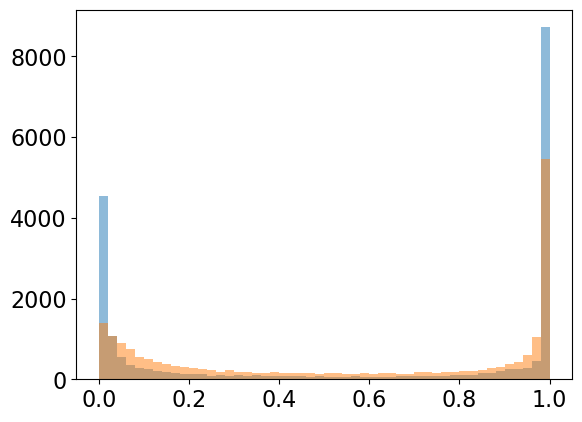

In [ ]:
plt.hist(y_pred_proba_crabnet,bins=50,range=(0,1), alpha=0.5)
plt.hist(y_pred_proba_roost,bins=50,range=(0,1), alpha=0.5)
plt.show()

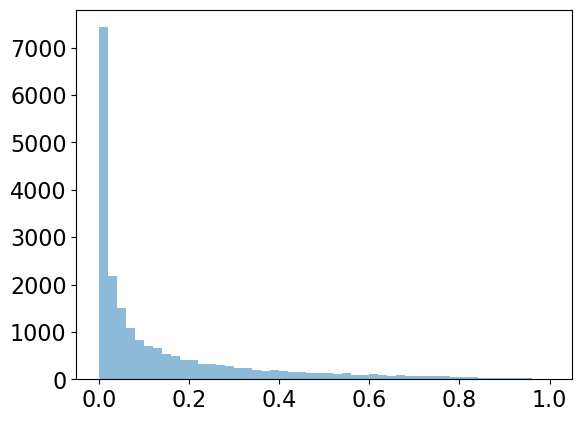

In [ ]:
plt.hist(np.abs(y_pred_proba_roost-y_pred_proba_crabnet),bins=50,range=(0,1), alpha=0.5)
plt.show()

In [ ]:
accuracy_score(y_pred_roost,y_pred_crabnet)

0.880675008389664

In [ ]:
df=pd.DataFrame()
df['formula']=formula
df['label']=y_true
df['crabnet']=y_pred_proba_crabnet
df['roost']=y_pred_proba_roost
df['crabnet_label']=y_pred_crabnet.astype(int)
df['roost_label']=y_pred_roost.astype(int)

In [ ]:
da=df.loc[df['label']==df['crabnet_label']]
db=da.loc[da['label']!=da['roost_label']]
db

,formula,label,crabnet,roost,crabnet_label,roost_label
45,Al6 Au2.25 Eu2 Si2.75,1.0,0.996719,0.323088,1,0
46,In11.76 Na7,1.0,0.752937,0.482390,1,0
54,Ni2 Pr0.945,1.0,0.997669,0.059760,1,0
56,Ni1 Pd1 Si2,1.0,0.865808,0.359713,1,0
59,Mn1 Nb2 O8 Zn2,0.0,0.141470,0.625605,0,1
...,...,...,...,...,...,...
20819,Ba3 O15 Ta5,0.0,0.109092,0.584031,0,1
20822,Dy4 Ni12 Sn25,0.0,0.322993,0.972229,0,1
20823,Nb4 O0.6 Rb6 S24.4,1.0,0.621940,0.116999,1,0
20843,H5 Eu2 Rh1,1.0,0.634416,0.385636,1,0


In [ ]:
da=df.loc[df['label']==df['roost_label']]
dc=da.loc[da['label']!=da['crabnet_label']]
dc

,formula,label,crabnet,roost,crabnet_label,roost_label
3,Te2 V1.04,0.0,0.899129,0.156443,1,0
16,Lu5 Mo2 O12,1.0,0.215111,0.528088,0,1
33,Mo4 O22 P4 Rb3,0.0,0.832558,0.121034,1,0
44,H54 Cl4 Co3 N33,1.0,0.320666,0.534450,0,1
75,Cu1 O7 V2 Zn1,1.0,0.208742,0.640481,0,1
...,...,...,...,...,...,...
20709,Cu0.5 Nb1 Se2,1.0,0.080588,0.862991,0,1
20715,C6 H20 Cl4 Hg1 N2,0.0,0.612588,0.094749,1,0
20717,Ba1 Nb0.5 O3 Tb0.5,1.0,0.341908,0.519833,0,1
20730,Pb4 S13 Sb6,1.0,0.337095,0.720140,0,1


In [ ]:
len(db)/len(df),len(dc)/len(df)

(0.08653339086245745, 0.03279160074787861)

In [ ]:
(len(db)+len(dc))/len(df)

0.11932499161033606